In [1]:
#@title ##### License
# Copyright 2020 Vascular Imaging Lab, University of Washington. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

# Intracranial artery labeling
This notebook and the accompanying code demonstrates how to use the Graph Nets library to learn to predict the intracranial artery types.

The code is associated with the paper from MICCAI 2020 Automated Intracranial Artery Labeling using a Graph Neural Network and Hierarchical Refinement

The network is trained to label the nodes (bifurcation/ending points) and edges (arteries) of the graph, given the features of the nodes and edges.

The graph neural network framework is based on Graph Nets library by DeepMind https://github.com/deepmind/graph_nets

## Install dependencies locally

If you are running this notebook locally (i.e., not through Colaboratory), you will also need to install a few more dependencies. Run the following on the command line to install the graph networks library, as well as a few other dependencies:

```
pip install graph_nets matplotlib scipy "tensorflow>=1.15,<2" "dm-sonnet<2" "tensorflow_probability<0.9"
```

In [2]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

<IPython.core.display.Javascript object>

# Libraries and variables

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import collections
import itertools
import time
import pickle
import copy
from itertools import permutations
import datetime

import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
from tensorflow.compat.v1.keras.backend import set_session

import tensorflow.compat.v1.keras.backend as K
# import keras.backend.tensorflow_backend as K  # for tf v2

config2 = tf.ConfigProto()
config2.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config2))

from graph_nets import graphs
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos import models
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy import spatial
import tensorflow as tf
from collections import Counter

SEED = 1
np.random.seed(SEED)
tf.set_random_seed(SEED)

print(tf.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.15.4


In [6]:
#model will be save in taskname folder
taskname = 'ArtLabel1'
if not os.path.exists(taskname):
    os.mkdir(taskname)

In [7]:
BOITYPENUM = 23
VESTYPENUM = 25

graphcache = {}

graphfoldername = 'graph/graphsim'

randaug = np.random.RandomState(seed=0)

# load datasets

In [8]:
#load datasets for training
from load_graph import prepare_graphs
dbnames = ['BRAVE','CROPCheck','ArizonaCheck','Parkinson2TPCheck','Anzhen']
# dbnames = ['CROPCheck','ArizonaCheck','Parkinson2TPCheck','Anzhen']
all_db = prepare_graphs(dbnames,graphfoldername)

print('='*50)
for key in all_db.keys():
    print('All db ',key,'len',len(all_db[key]))

#check all pickle graph exist
assert np.array([os.path.exists(i) for i in np.concatenate([all_db[j] for j in all_db])]).all()

Load from db list graph/graphsim/BRAVE/db.list
train len 0 117
val len 0 25
test len 0 25
Load from db list graph/graphsim/CROPCheck/db.list
train len 117 117
val len 25 25
test len 25 25
Load from db list graph/graphsim/ArizonaCheck/db.list
train len 234 111
val len 50 32
test len 50 17
Load from db list graph/graphsim/Parkinson2TPCheck/db.list
train len 345 117
val len 82 24
test len 67 28
Load from db list graph/graphsim/Anzhen/db.list
train len 462 46
val len 106 10
test len 95 10
All db  train len 508
All db  val len 116
All db  test len 105


In [9]:
np.concatenate([all_db[j] for j in all_db]).shape

(729,)

In [10]:
from load_graph import generate_graph
print(all_db['train'][0])
G = generate_graph(graphcache,all_db['train'][0],randaug)

graph/graphsim/BRAVE/0_7079_U.pickle


In [11]:
graphcache


{'0_7079_U.pickle': <networkx.classes.graph.Graph at 0x181363e9cc8>}

<BarContainer object of 23 artists>

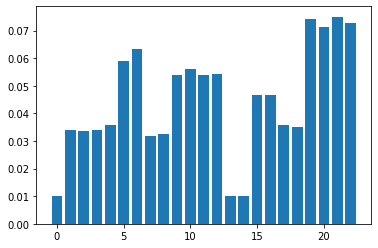

In [13]:
# frequency count from node types
boitypes = []  #  bifurcations of interest (BOI)
for picklei in all_db['train'][::-1]:
    G = generate_graph(graphcache,picklei,randaug)
    boitypes.extend([ni['boitype'] for i,ni in G.nodes(data=True)])
node_class_ct = Counter(boitypes)
node_class_weightr = []
for i in range(BOITYPENUM):
    if node_class_ct[i]!=0:
        node_class_weightr.append(1/node_class_ct[i])
    else:
        node_class_weightr.append(0)
sumweights = np.sum(node_class_weightr)
node_class_weight = np.array([max(0.01,i/sumweights) for i in node_class_weightr]).astype(np.float64)
plt.bar(np.arange(BOITYPENUM),node_class_weight)

<BarContainer object of 25 artists>

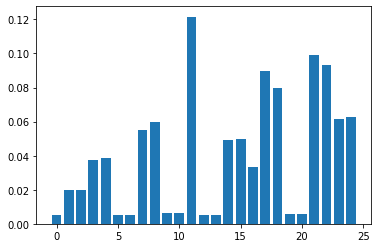

In [14]:
# frequency count from edge types
vestypes = []
for picklei in all_db['train']:
    G = generate_graph(graphcache,picklei,randaug)
    vestypes.extend([np.argmax(ni['vestype']) for i,j,ni in G.edges(data=True)])
edge_class_ct = Counter(vestypes)
edge_class_weightr = []
for i in range(VESTYPENUM):
    if edge_class_ct[i]!=0:
        edge_class_weightr.append(1/edge_class_ct[i])
    else:
        edge_class_weightr.append(0)
sumweights = np.sum(edge_class_weightr)
edge_class_weight = np.array([max(0.005,i/sumweights) for i in edge_class_weightr]).astype(np.float64)
plt.bar(np.arange(VESTYPENUM),edge_class_weight)

## Visualize example graphs

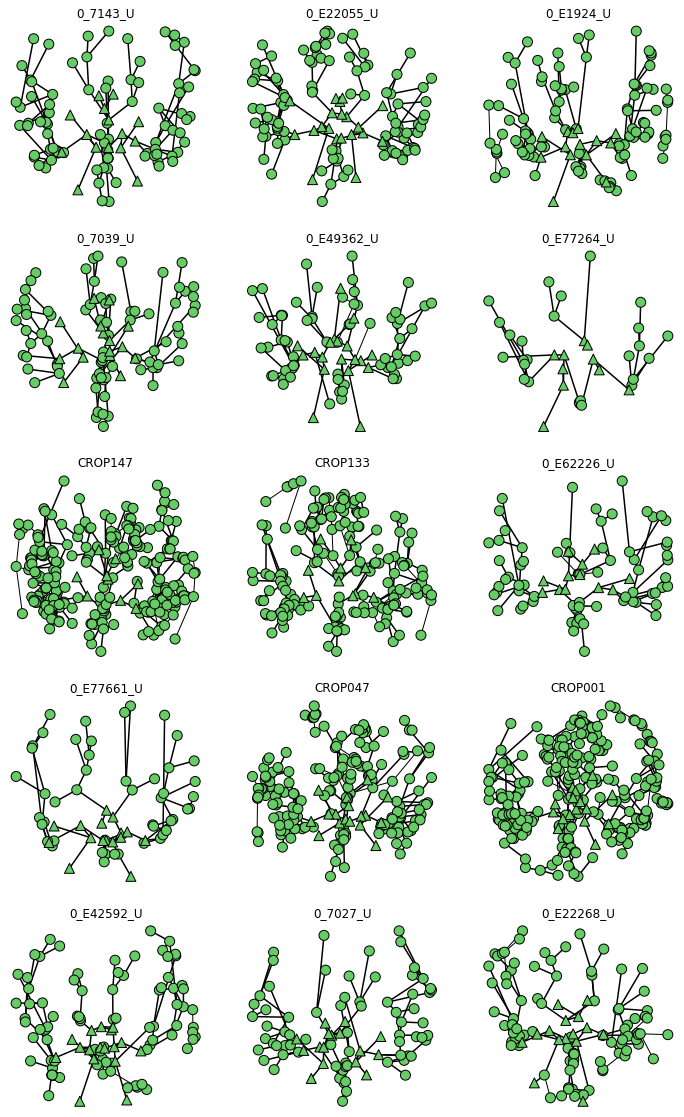

In [11]:
from gnn_utils import *

seed = 1  #@param{type: 'integer'}
rand = np.random.RandomState(seed=seed)

num_examples = 15  #@param{type: 'integer'}

input_graphs, target_graphs, graphs, selids = generate_networkx_graphs(graphcache, all_db, rand, num_examples,'train')

num = min(num_examples, 16)
w = 3
h = int(np.ceil(num / w))
fig = plt.figure(40, figsize=(w * 4, h * 4))
fig.clf()
for j, graph in enumerate(graphs):
    ax = fig.add_subplot(h, w, j + 1)
    pos = get_node_dict(graph, "pos", ignoreaxis = 2)
    plotter = GraphPlotter(ax, graph, pos)
    plotter.title = os.path.basename(all_db['train'][selids[j]])[:-7]
    plotter.draw_graph_with_solution()

In [12]:
#@title Set up model training and evaluation  { form-width: "30%" }

# The model we explore includes three components:
# - An "Encoder" graph net, which independently encodes the edge, node, and
#   global attributes (does not compute relations etc.).
# - A "Core" graph net, which performs N rounds of processing (message-passing)
#   steps. The input to the Core is the concatenation of the Encoder's output
#   and the previous output of the Core (labeled "Hidden(t)" below, where "t" is
#   the processing step).
# - A "Decoder" graph net, which independently decodes the edge, node, and
#   global attributes (does not compute relations etc.), on each
#   message-passing step.
#
#                     Hidden(t)   Hidden(t+1)
#                        |            ^
#           *---------*  |  *------*  |  *---------*
#           |         |  |  |      |  |  |         |
# Input --->| Encoder |  *->| Core |--*->| Decoder |---> Output(t)
#           |         |---->|      |     |         |
#           *---------*     *------*     *---------*
#
# The model is trained by supervised learning. Input graphs are procedurally
# generated, and output graphs have the same structure with the nodes and edges
# of the shortest path labeled (using 2-element 1-hot vectors). We could have
# predicted the shortest path only by labeling either the nodes or edges, and
# that does work, but we decided to predict both to demonstrate the flexibility
# of graph nets' outputs.
#
# The training loss is computed on the output of each processing step. The
# reason for this is to encourage the model to try to solve the problem in as
# few steps as possible. It also helps make the output of intermediate steps
# more interpretable.
#
# There's no need for a separate evaluate dataset because the inputs are
# never repeated, so the training loss is the measure of performance on graphs
# from the input distribution.
#
# We also evaluate how well the models generalize to graphs which are up to
# twice as large as those on which it was trained. The loss is computed only
# on the final processing step.
#
# Variables with the suffix _tr are training parameters, and variables with the
# suffix _ge are test/generalization parameters.
#
# After around 2000-5000 training iterations the model reaches near-perfect
# performance on graphs with between 8-16 nodes.

tf.reset_default_graph()

seed = 2
rand = np.random.RandomState(seed=seed)

# Model parameters.
# Number of processing (message-passing) steps.
num_processing_steps_tr = 10
num_processing_steps_ge = 10

# Data / training parameters.
num_training_iterations = 70000
batch_size_tr = min(len(all_db['train']),32)
batch_size_ge = len(all_db['val'])

# Data.
# Input and target placeholders.
input_ph, target_ph = create_placeholders(graphcache, rand, batch_size_tr, all_db)

# Connect the data to the model.
# Instantiate the model.
model = models.EncodeProcessDecode(edge_output_size=VESTYPENUM, node_output_size=BOITYPENUM)
# A list of outputs, one per processing step.
output_ops_tr = model(input_ph, num_processing_steps_tr)
output_ops_ge = model(input_ph, num_processing_steps_ge)

# Training loss.
loss_ops_tr = create_loss_ops(target_ph, output_ops_tr,node_class_weight,edge_class_weight,weighted=True)

# Loss across processing steps.
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr

# Test/generalization loss.
loss_ops_ge = create_loss_ops(target_ph, output_ops_ge,node_class_weight,edge_class_weight,weighted=False)
loss_op_ge = loss_ops_ge[-1]  # Loss from final processing step.

# Optimizer.
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)

# Lets an iterable of TF graphs be output from a session as NP graphs.
input_ph, target_ph = make_all_runnable_in_session(input_ph, target_ph)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.




c:\programdata\miniconda3\envs\gnn-art-label\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\programdata\miniconda3\envs\gnn-art-label\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\programdata\miniconda3\envs\gnn-art-label\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\programdata\miniconda3\envs\gnn-art-label\lib\sit

In [18]:
#@title Reset session  { form-width: "30%" }

# This cell resets the Tensorflow session, but keeps the same computational
# graph.

try:
    sess.close()
except NameError:
    pass
sess = tf.Session()
sess.run(tf.global_variables_initializer())

last_iteration = 0
logged_iterations = []
losses_tr = []
corrects_tr = []
solveds_tr = []
corrects_tr_e = []
solveds_tr_e = []
corrects_tr_n = []
solveds_tr_n = []

losses_ge = []
corrects_ge = []
solveds_ge = []
corrects_ge_e = []
solveds_ge_e = []
corrects_ge_n = []
solveds_ge_n = []

saver = tf.train.Saver()

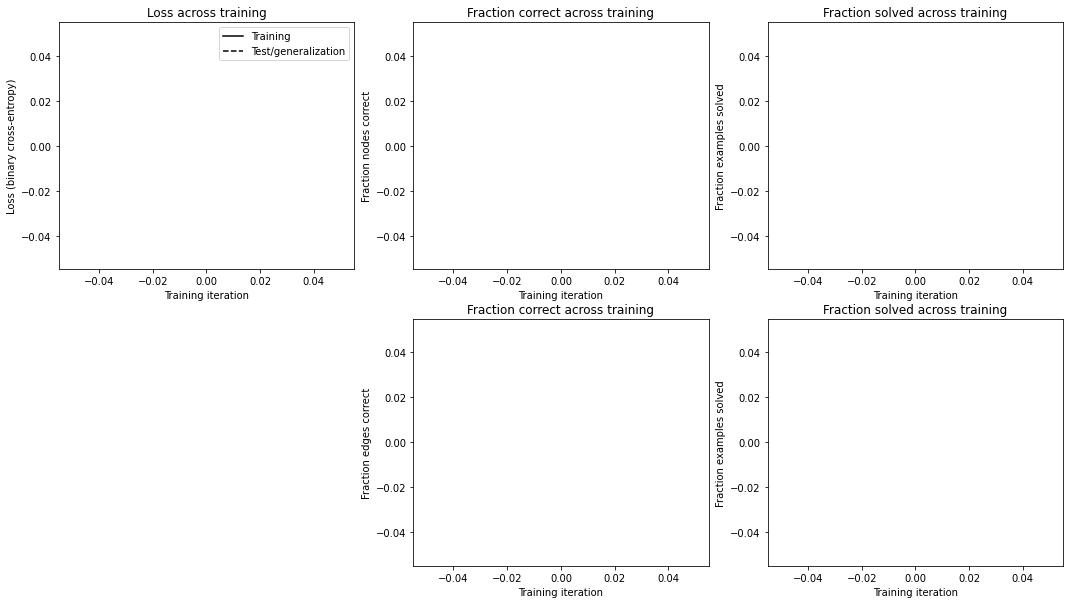

In [19]:
def pltloss():
    #@title Visualize results  { form-width: "30%" }

    # This cell visualizes the results of training. You can visualize the
    # intermediate results by interrupting execution of the cell above, and running
    # this cell. You can then resume training by simply executing the above cell
    # again.

    # Plot results curves.
    fig = plt.figure(1, figsize=(18, 10))
    fig.clf()
    x = np.array(logged_iterations)
    # Loss.
    y_tr = losses_tr
    y_ge = losses_ge
    ax = fig.add_subplot(2, 3, 1)
    ax.plot(x, y_tr, "k", label="Training")
    ax.plot(x, y_ge, "k--", label="Test/generalization")
    ax.set_title("Loss across training")
    ax.set_xlabel("Training iteration")
    ax.set_ylabel("Loss (binary cross-entropy)")
    ax.legend()
    # Correct.
    y_tr = corrects_tr_n
    y_ge = corrects_ge_n
    ax = fig.add_subplot(2, 3, 2)
    ax.plot(x, y_tr, "k", label="Training")
    ax.plot(x, y_ge, "k--", label="Test/generalization")
    ax.set_title("Fraction correct across training")
    ax.set_xlabel("Training iteration")
    ax.set_ylabel("Fraction nodes correct")
    # Solved.
    y_tr = solveds_tr_n
    y_ge = solveds_ge_n
    ax = fig.add_subplot(2, 3, 3)
    ax.plot(x, y_tr, "k", label="Training")
    ax.plot(x, y_ge, "k--", label="Test/generalization")
    ax.set_title("Fraction solved across training")
    ax.set_xlabel("Training iteration")
    ax.set_ylabel("Fraction examples solved")

    # Correct.
    y_tr = corrects_tr_e
    y_ge = corrects_ge_e
    ax = fig.add_subplot(2, 3, 5)
    ax.plot(x, y_tr, "k", label="Training")
    ax.plot(x, y_ge, "k--", label="Test/generalization")
    ax.set_title("Fraction correct across training")
    ax.set_xlabel("Training iteration")
    ax.set_ylabel("Fraction edges correct")
    # Solved.
    y_tr = solveds_tr_e
    y_ge = solveds_ge_e
    ax = fig.add_subplot(2, 3, 6)
    ax.plot(x, y_tr, "k", label="Training")
    ax.plot(x, y_ge, "k--", label="Test/generalization")
    ax.set_title("Fraction solved across training")
    ax.set_xlabel("Training iteration")
    ax.set_ylabel("Fraction examples solved")
    plt.show()
pltloss()

In [20]:
#@title Run training  { form-width: "30%" }

# You can interrupt this cell's training loop at any time, and visualize the
# intermediate results by running the next cell (below). You can then resume
# training by simply executing this cell again.

# How much time between logging and printing the current results.
log_every_seconds = 60
num_training_iterations = 2000


print("# (iteration number), T (elapsed seconds), "
      "Ltr (training loss), Lge (test/generalization loss), "
      "Ctr (training fraction nodes/edges labeled correctly), "
      "Str (training fraction examples solved correctly), "
      "Cge (test/generalization fraction nodes/edges labeled correctly), "
      "Sge (test/generalization fraction examples solved correctly)")

start_time = time.time()
last_log_time = start_time

for iteration in range(last_iteration, num_training_iterations):
    last_iteration = iteration
    feed_dict, _, _ = create_feed_dict(all_db, rand, batch_size_tr, input_ph, target_ph, 'train', graphcache)
    train_values = sess.run({
      "step": step_op,
      "target": target_ph,
      "loss": loss_op_tr,
      "outputs": output_ops_tr
    }, feed_dict=feed_dict)

    the_time = time.time()
    elapsed_since_last_log = the_time - last_log_time

    if elapsed_since_last_log > log_every_seconds:
        last_log_time = the_time
        feed_dict, raw_graphs, _ = create_feed_dict(all_db, rand, batch_size_ge, input_ph, target_ph, 'val', graphcache)
        test_values = sess.run({
            "target": target_ph,
            "loss": loss_op_ge,
            "outputs": output_ops_ge
        }, feed_dict=feed_dict)
        
        correct_tr, solved_tr = compute_accuracy(train_values["target"], train_values["outputs"][-1], use_nodes=True, use_edges=True)
        correct_ge, solved_ge = compute_accuracy(test_values["target"], test_values["outputs"][-1], use_nodes=True, use_edges=True)
        
        correct_tr_n, solved_tr_n = compute_accuracy(train_values["target"], train_values["outputs"][-1], use_nodes=True, use_edges=False)
        correct_ge_n, solved_ge_n = compute_accuracy(test_values["target"], test_values["outputs"][-1], use_nodes=True, use_edges=False)
        
        correct_tr_e, solved_tr_e = compute_accuracy(train_values["target"], train_values["outputs"][-1], use_nodes=False, use_edges=True)
        correct_ge_e, solved_ge_e = compute_accuracy(test_values["target"], test_values["outputs"][-1], use_nodes=False, use_edges=True)
        
        elapsed = time.time() - start_time
        
        losses_tr.append(train_values["loss"])
        corrects_tr.append(correct_tr)
        solveds_tr.append(solved_tr)
        corrects_tr_n.append(correct_tr_n)
        solveds_tr_n.append(solved_tr_n)
        corrects_tr_e.append(correct_tr_e)
        solveds_tr_e.append(solved_tr_e)
        
        losses_ge.append(test_values["loss"])
        corrects_ge.append(correct_ge)
        solveds_ge.append(solved_ge)
        corrects_ge_n.append(correct_ge_n)
        solveds_ge_n.append(solved_ge_n)
        corrects_ge_e.append(correct_ge_e)
        solveds_ge_e.append(solved_ge_e)
        
        logged_iterations.append(iteration)
        
        print("# {:05d}, T {:.1f}, Ltr {:.4f}, Lge {:.4f},\n Ctr {:.4f}, Str {:.4f}, Cge {:.4f}, Sge {:.4f}\n"
              " CtrN {:.4f}, StrN {:.4f}, CgeN {:.4f}, SgeN {:.4f} \n CtrE {:.4f}, StrE {:.4f}, CgeE {:.4f}, SgeE {:.4f}".format(
                  iteration, elapsed, train_values["loss"], test_values["loss"],
                  correct_tr, solved_tr, correct_ge, solved_ge,
                  correct_tr_n, solved_tr_n, correct_ge_n, solved_ge_n,
                  correct_tr_e, solved_tr_e, correct_ge_e, solved_ge_e))
        
        
        if iteration>10000 and \
            (test_values["loss"] == np.min(losses_ge) or \
             correct_ge_n == np.max(corrects_ge_n) or \
             correct_ge_e == np.max(corrects_ge_e)):
            save_path = saver.save(sess, taskname+"/model%d-%.4f-%.4f-%.4f.ckpt"%(iteration,test_values["loss"],correct_ge_n,correct_ge_e))
            print("Val loss decrease. Model saved in path: %s" % save_path)
            print('Cge {:.4f} {:.4f} {:.4f}, Sge {:.4f} Loss_gen {:.4f}'
                  .format(correct_ge, correct_ge_n, correct_ge_e, solved_ge, test_values["loss"]))
            pltloss()
            np.save(taskname+'/losses.npy',[last_iteration,logged_iterations,losses_tr,corrects_tr,solveds_tr,corrects_tr_e,solveds_tr_e,corrects_tr_n,solveds_tr_n,losses_ge,corrects_ge,solveds_ge,corrects_ge_e,solveds_ge_e,corrects_ge_n,solveds_ge_n])

# (iteration number), T (elapsed seconds), Ltr (training loss), Lge (test/generalization loss), Ctr (training fraction nodes/edges labeled correctly), Str (training fraction examples solved correctly), Cge (test/generalization fraction nodes/edges labeled correctly), Sge (test/generalization fraction examples solved correctly)
# 00209, T 183.4, Ltr nan, Lge nan,
 Ctr 0.5454, Str 0.0000, Cge 0.5397, Sge 0.0000
 CtrN 0.8776, StrN 0.0000, CgeN 0.8798, SgeN 0.0000 
 CtrE 0.2065, StrE 0.0000, CgeE 0.1954, SgeE 0.0000


KeyboardInterrupt: 

In [ ]:
pltloss()

In [ ]:
#save model for current iteration 
#save_path = saver.save(sess, taskname+"/model%d.ckpt"%iteration)
save_path = saver.save(sess, taskname+"/model%d-%.4f-%.4f-%.4f.ckpt"%(iteration,test_values["loss"],correct_ge_n,correct_ge_e))
np.save(taskname+'/losses.npy',[last_iteration,logged_iterations,losses_tr,corrects_tr,solveds_tr,corrects_tr_e,solveds_tr_e,corrects_tr_n,solveds_tr_n,losses_ge,corrects_ge,solveds_ge,corrects_ge_e,solveds_ge_e,corrects_ge_n,solveds_ge_n])            
print("Model saved in path: %s" % save_path)
pltloss()

# Evaluate on test set

In [ ]:
import glob
valbest = 'valloss'
#valbest = 'nodeacc'
savedmodels = glob.glob(taskname+'/*ckpt.index')
if valbest == 'valloss':
    bestvalid = np.argmin([float(os.path.basename(i)[:-11].split('-')[1]) for i in savedmodels])
elif valbest == 'nodeacc':
    bestvalid = np.argmax([float(os.path.basename(i)[:-11].split('-')[2]) for i in savedmodels])
elif valbest == 'edgeacc':
    bestvalid = np.argmax([float(os.path.basename(i)[:-11].split('-')[3]) for i in savedmodels])

valmodelfilename = savedmodels[bestvalid][:-6]
# Restore variables from disk.
saver.restore(sess, valmodelfilename)
print("Model restored epoch",valmodelfilename)



In [ ]:
#load test set and predict
starttime = datetime.datetime.now()
feed_dict, raw_graphs, selids = create_feed_dict(all_db, rand, len(all_db['test']), input_ph, target_ph, 'test',graphcache)

test_values = sess.run({
            "target": target_ph,
            "loss": loss_op_ge,
            "outputs": output_ops_ge
        },
                               feed_dict=feed_dict)
targets = utils_np.graphs_tuple_to_data_dicts(test_values["target"])
outputs = list(
    zip(*(utils_np.graphs_tuple_to_data_dicts(test_values["outputs"][i])
          for i in range(len(test_values["outputs"])))))

endtime = datetime.datetime.now()
print((endtime-starttime).total_seconds()/len(all_db['test']))

# direct output from GNN
#modify output from network
rawoutputs = []
for ti,outputr in enumerate(outputs):
    output = copy.copy(outputr[-1])
    '''for edgei in range(output['edges'].shape[0]):
        #add prob m3 to m2
        output['edges'][edgei][5] += output['edges'][edgei][12]
        output['edges'][edgei][12] = 0
        output['edges'][edgei][6] += output['edges'][edgei][13]
        output['edges'][edgei][13] = 0'''
    rawoutputs.append(copy.deepcopy(output))

# Hierarchical Refinement

## collect ves branch length

In [ ]:

from hr_utils import nodeconnection, matchvestype, nodedist, edgemap

branch_dist_mean = {}
branch_dist_std = {}
branchdists = [[] for i in range(VESTYPENUM)]

for gi in all_db['train'][:]:
    G = generate_graph(graphcache,gi,randaug)
    cnode_type_to_id = {}
    for nodei in G.nodes():
        cnodetype = G.nodes[nodei]['boitype']
        if cnodetype!=0:
            cnode_type_to_id[cnodetype] = nodei
    #print(cnode_type_to_id)
    #edge according to node
    for nodetypei in range(len(nodeconnection)):
        if len(nodeconnection[nodetypei])==0:
            continue
        if nodetypei not in cnode_type_to_id.keys():
            continue
        for branchnodetypei in nodeconnection[nodetypei]:
            if branchnodetypei not in cnode_type_to_id.keys() or nodetypei not in cnode_type_to_id.keys():
                continue
            edgetype = matchvestype(nodetypei,branchnodetypei)
            try:
                sp = nx.shortest_path(G,cnode_type_to_id[nodetypei],cnode_type_to_id[branchnodetypei])
            except nx.NetworkXNoPath:
                print('no path between',nodetypei,branchnodetypei,gi)
                continue
            cdist = nodedist(G,cnode_type_to_id[nodetypei],cnode_type_to_id[branchnodetypei])
            branchdists[edgetype].append(cdist)

    #additional edges based on node types
    for edgetype,nodetypes in edgemap.items():
        if nodetypes[0] not in cnode_type_to_id.keys() or nodetypes[1] not in cnode_type_to_id.keys():
            continue
        
        edgetype = matchvestype(nodetypes[0],nodetypes[1])
        try:
            sp = nx.shortest_path(G,cnode_type_to_id[nodetypes[0]],cnode_type_to_id[nodetypes[1]])
        except nx.NetworkXNoPath:
            print('no path between',nodetypes,gi)
            continue
        cdist = nodedist(G,cnode_type_to_id[nodetypes[0]],cnode_type_to_id[nodetypes[1]])
        branchdists[edgetype].append(cdist)
for vestype,dists in enumerate(branchdists):
    if len(dists)==0:
        continue
    branch_dist_mean[vestype] = np.mean(dists)
    branch_dist_std[vestype] = np.std(dists)
    print(vestype,branch_dist_mean[vestype],branch_dist_std[vestype])
    

## ground truth construction from graph

In [ ]:
#set the range for test
trange = np.arange(len(raw_graphs))
#trange = np.arange(2)

In [ ]:
from hr_utils import findedgeid, edgefromnode

gtsr = []
for ti in trange:
    graph = raw_graphs[ti]
    target = targets[ti]
    graphname = os.path.basename(all_db['test'][selids[ti]])[:-7]
    print('='*40,'\n','ti',ti,graphname)
    #prob for all edges and nodes
    targetnodes = np.argmax(target['nodes'],axis=1)
    
    ground_truth = [np.argmax(ni) for ni in target["nodes"]]
    ground_truth_edge = []
    for ni in target["edges"]:
        if np.max(ni)!=0:
            ground_truth_edge.append(np.argwhere(ni)[0])
        else:
            ground_truth_edge.append(0)
    
    #merge m23
    for i,v in enumerate(ground_truth_edge):
        if v==12:
            ground_truth_edge[i] = 5
        if v==13:
            ground_truth_edge[i] = 6
        
    #correct wrong pcomm labels, p1/2/pcomm at node 1
    if 19 in ground_truth:
        pcomp1p2id = ground_truth.index(19)
        if graph.nodes[pcomp1p2id]['deg']==1:
            print('pcomml has deg 1')
            ground_truth[pcomp1p2id]=0
            if 21 in ground_truth:
                pcomicaid = ground_truth.index(21)
                ground_truth[pcomicaid]=0
                #edge
                edgeid = findedgeid(graph,pcomp1p2id,pcomicaid)
                ground_truth_edge[edgeid] = 0
            
    #pcomm to p2
    if 21 in ground_truth and 19 not in ground_truth:
        print('pcomml to p2')
        
    #correct wrong pcomm labels
    if 20 in ground_truth:
        pcomp1p2id = ground_truth.index(20)
        if graph.nodes[pcomp1p2id]['deg']==1:
            print('pcommr has deg 1')
            ground_truth[pcomp1p2id]=0
            if 22 in ground_truth:
                pcomicaid = ground_truth.index(22)
                ground_truth[pcomicaid]=0
                #edge
                edgeid = findedgeid(graph,pcomp1p2id,pcomicaid)
                ground_truth_edge[edgeid] = 0
            
    #pcomm to p2
    if 22 in ground_truth and 20 not in ground_truth:
        print('pcomml to p2')
        
    for i, n in enumerate(graph.nodes()):
        #ignore abnormal ground truth label, likely to be a manual error in labeling
        if ground_truth[i]!=0 and graph.nodes[i]['deg']!=len(edgefromnode[ground_truth[i]]):
            print('Gt',ground_truth[i],'deg',graph.nodes[i]['deg'],'!=',len(edgefromnode[ground_truth[i]]))

    #search type A12 P12, set edge gt type from ap1 to ap2 if node is not deg 3
    for i, n in enumerate(graph.edges()):
        ap12edgetype = [7,8,17,18]
        if ground_truth_edge[i] in ap12edgetype:
            #if deg 3 p1/2 a1/2 exist, edge correct label
            #ap12edgetype-2 node type a1/2/acomm
            if ground_truth_edge[i] in [7,8] and ground_truth_edge[i]-2 in ground_truth and graph.nodes[ground_truth.index(ground_truth_edge[i]-2)]['deg']==3:
                continue
            if ground_truth_edge[i] in [17,18] and ground_truth_edge[i]+2 in ground_truth and graph.nodes[ground_truth.index(ground_truth_edge[i]+2)]['deg']==3:
                continue
            ground_truth_edge[i] = ground_truth_edge[i]+2
            print('ap12 set to ap2',ground_truth_edge[i])
    
    gt = {}
    gt['nodes'] = ground_truth
    gt['edges'] = ground_truth_edge
    gt['name'] = graphname
    gtsr.append(gt)

## refinement using HR

In [ ]:
from hr_utils import softmax_probs, find_node_connection_ids, findmaxprob,findallnei,find_nei_nodes
#test confident node acc
compset = set([1,2,3,4,5,6,7,8,17,18,19,20])
#edgetype:[nodetypes]
edgemap = {11:[5,6],21:[19,21],22:[20,22],23:[9,11],24:[10,12],14:[15,17],15:[16,17]}
#for M2 A2 P2, from proximal to distal, third number is edge type
fillmap = [[3,7,5],[4,8,6],[3,5,9],[4,6,10],[18,19,19],[18,20,20]]
center_node_prob_thres = 1e-10

fitacc = 0
errfitacc = 0
errlist = []

#refined output
refoutputs = []

starttime = datetime.datetime.now()
for ti in trange:
    graph = raw_graphs[ti]
    target = targets[ti]
    output = outputs[ti]
    #find vestype in degree 2 
    deg2edge = []
    deg2node = []
    graphname = os.path.basename(all_db['test'][selids[ti]])[:-7]
    print('='*40,'\n','ti',ti,graphname)
    #prob for all edges and nodes
    probedges = softmax_probs(output[-1]["edges"])
    probnodes = softmax_probs(output[-1]["nodes"])
    prededges = np.argmax(output[-1]["edges"],axis=1)
    prednodes = np.argmax(output[-1]["nodes"],axis=1)
    targetnodes = np.argmax(target['nodes'],axis=1)

    edges = list(graph.edges())
    
    #key:nodeid, value:landmarkid
    node_type_to_id = {}
    prob_conf_type = {}
    
    coredge = [[] for i in range(output[-1]["edges"].shape[0])]
    for nodei in graph.nodes():
        #probability of each edge
        probedge = {}
        #predicted as edge type
        prededge = []
        #neighboring edge ids
        nei_edge_ids = find_node_connection_ids(graph,nodei)
        
        for edgeid in nei_edge_ids:
            probedge[edgeid] = np.max(probedges[edgeid])
            prededge.append(prededges[edgeid])
            
        #node prob
        probnode = np.max(probnodes[nodei])
        prednode = prednodes[nodei]
        #print('node predict',np.argmax(probnodes[nodei]))

        #conf nodes predicted in [0,9,10,11,12,21,22] are not useful in hierachical framework 
        if prednode not in [0] and sorted(prededge)==edgefromnode[prednode]:
            if prednode not in [0,9,10,11,12,15,16,21,22]:
                if prednode in node_type_to_id.keys():
                    print('pred node type exist',probnode,'exist prob',prob_conf_type[prednode])
                    if probnode < prob_conf_type[prednode]:
                        print('skip')
                        continue
                    else:
                        print('override')
                node_type_to_id[prednode] = nodei
                prob_conf_type[prednode] = probnode
                    
            print('Fit edge set',prededge,'node',prednode,'gt',targetnodes[nodei])
            if targetnodes[nodei]!=0:
                fitacc += 1
                
            if prednode != targetnodes[nodei]:
                if targetnodes[nodei]!=0:
                    errfitacc += 1
                    errlist.append([prededge,prednode,targetnodes[nodei],all_db['test'][ti]])
            
            
       
    
    #from nodetype to nodeid
    node_id_to_type = {node_type_to_id[i]:i for i in node_type_to_id}
    print('key node unconfident',compset-set(node_id_to_type.values()))
    ##########################################
    #start with key nodes
    #anterior L(3) R(4)/posterior(18) circulation
    treenodes = {3:[1,5,7],4:[2,6,8],18:[17,19,20]}
    for center_node_type in [3,4,18]:
        failcenter = 0
        print('@@@Predicting centernode',center_node_type)
        #if center node not exist, find from neighbor first
        if center_node_type not in node_id_to_type.values():
            #from confident branch nodes find center nodes
            cofnodes = [i for i in node_id_to_type.values() if i in nodeconnection[center_node_type]]
            print('center node not confident, branch confident nodes',cofnodes)
            if len(cofnodes)==0:
                print('whole circulation cannot be confidently predicted, use max prob')
                failcenter = 1
            elif len(cofnodes)==1:
                print('predict using single node')
                cedgetype = matchvestype(cofnodes[0],center_node_type)
                nei_edge_ids = list(graph.edges(node_type_to_id[cofnodes[0]]))
                nodestart = [edgei[1] for edgei in nei_edge_ids if prededges[findedgeid(graph,edgei[0],edgei[1])]==cedgetype]
                assert len(nodestart)==1
                otherbranchnodes = set(np.concatenate(list(treenodes.values())+[list(treenodes.keys())]))-set(treenodes[center_node_type])
                visited = [node_type_to_id[cofnodes[0]],nodestart[0]]+[node_type_to_id[i] for i in otherbranchnodes if i in node_type_to_id.keys()]
                print('exclude other branch nodeid',[[i,node_type_to_id[i]] for i in otherbranchnodes if i in node_type_to_id.keys()])
                exp_edge_type = matchvestype(cofnodes[0],center_node_type)
                #neighbors of major nodes have degree of 1(branch length > 10),3,3 or 3,3,3 
                center_node_pred = findmaxprob(graph,nodestart[0],visited,center_node_type,
                                               len(edgefromnode[center_node_type]), exp_edge_type, 
                                               probnodes,branch_dist_mean,branch_dist_std, majornode=True)
            elif len(cofnodes)==2:
                print('predict using two nodes')
                try:
                    #1:-1 remove start and end node
                    pathnodeid = nx.shortest_path(graph,node_type_to_id[cofnodes[0]],node_type_to_id[cofnodes[1]])[1:-1]
                except nx.NetworkXNoPath:
                    print('no shortest path  between confident nodes, skip')
                    failcenter = 1
                 
                center_node_pred = pathnodeid[np.argmax([probnodes[ni][center_node_type] for ni in pathnodeid])]
            elif len(cofnodes)==3:
                print('predict using three nodes')
                center_node_pred_set = list(set(nx.shortest_path(graph,node_type_to_id[cofnodes[0]],node_type_to_id[cofnodes[1]]))&\
                                    set(nx.shortest_path(graph,node_type_to_id[cofnodes[0]],node_type_to_id[cofnodes[2]]))&\
                                    set(nx.shortest_path(graph,node_type_to_id[cofnodes[1]],node_type_to_id[cofnodes[2]])))
                if len(center_node_pred_set)==1:
                    center_node_pred = center_node_pred_set[0]
                elif len(center_node_pred_set)==0:
                    print('no common node for three path')
                    failcenter = 1
                else:
                    print('center_node_pred_set has more than 1 node',center_node_pred_set)
            else:
                print('more than three nodes.possible?')

            low_prob_center = 0
            if failcenter:
                #center_node_pred = np.argmax([probnodes[i][center_node_type] for i in range(probnodes.shape[0])])
                center_probs = {i:probnodes[i][center_node_type] for i in range(probnodes.shape[0]) if i not in list(node_id_to_type.keys())}
                center_node_pred = sorted(center_probs.items(), key=lambda item: -item[1])[0][0]
                print('center predict by most prob')
            
            if probnodes[center_node_pred][center_node_type]<center_node_prob_thres or low_prob_center:
                print('center node prob too low',probnodes[center_node_pred][center_node_type],', this may because of missing such center node type. use default')
                #need to ensure branch nodes on ICA-M1, BA-P1 are oredicted
                #start from root nodes
                branch_node_type = treenodes[center_node_type][0]
                if branch_node_type not in node_type_to_id.keys():
                    print('Use max prob to predict root node type',branch_node_type)
                    if center_node_type in [3,4]:
                        branch_probs = {i:probnodes[i][branch_node_type] for i in range(probnodes.shape[0]) if graph.nodes[i]['deg']==1 and i not in list(node_id_to_type.keys())}
                    else:
                        branch_probs = {i:probnodes[i][branch_node_type] for i in range(probnodes.shape[0]) if i not in list(node_id_to_type.keys())}
                    branch_node_pred = sorted(branch_probs.items(), key=lambda item: -item[1])[0][0]
                    if probnodes[branch_node_pred][branch_node_type]<center_node_prob_thres:
                        print('no prob over thres for branch node type',branch_node_type)
                    else:
                        print('Branch node type',branch_node_type,'nodeid',branch_node_pred,'gt',targetnodes[branch_node_pred])
                        node_type_to_id[branch_node_type] = branch_node_pred
                        node_id_to_type[branch_node_pred] = branch_node_type
                #A1 can be missing, M1 cannot
                if center_node_type in [3,4]:
                    branch_node_type2 = treenodes[center_node_type][1] 
                    if branch_node_type2 not in node_type_to_id.keys():
                        print('Use max prob to predict root node type',branch_node_type2)
                        if branch_node_type in node_type_to_id.keys():
                            visited = [node_type_to_id[branch_node_type]]+list(node_type_to_id.keys())
                            print('search neighbors of branch nodeid',node_type_to_id[branch_node_type])
                            nodestart = [i[1] for i in list(graph.edges(node_type_to_id[branch_node_type]))]
                            assert len(nodestart)==1
                            branch_node_pred2 = findmaxprob(graph,nodestart[0],visited,branch_node_type2,\
                                                           len(edgefromnode[branch_node_type2]),probnodes,branch_dist_mean,branch_dist_std)
                        else:
                            print('Root Branch not confident, use max prob for node type',branch_node_type2)
                            branch_probs2 = {i:probnodes[i][branch_node_type2] for i in range(probnodes.shape[0]) if graph.nodes[i]['deg']==3 and i not in list(node_id_to_type.keys())}
                            branch_node_pred2 = sorted(branch_probs2.items(), key=lambda item: -item[1])[0][0]

                        print('Minor Branch node type',branch_node_type2,'nodeid',branch_node_pred2,'gt',targetnodes[branch_node_pred2])
                        node_type_to_id[branch_node_type2] = branch_node_pred2
                        node_id_to_type[branch_node_pred2] = branch_node_type2
                        
                        #tentative A1
                        branch_node_type3 = treenodes[center_node_type][2]
                        if branch_node_type3 not in node_type_to_id.keys():
                            print('Pred A1')
                            visited = list(node_type_to_id.keys())
                            print('search neighbors of branch nodeid',node_type_to_id[branch_node_type2])
                            
                            branch_node_pred2 = findmaxprob(graph,node_type_to_id[branch_node_type2],visited,\
                                                            branch_node_type3,\
                                                           len(edgefromnode[branch_node_type3]),probnodes,branch_dist_mean,branch_dist_std)
                            print('prob a1/2',probnodes[branch_node_pred2][branch_node_type2])
                            if probnodes[branch_node_pred2][branch_node_type2]<center_node_prob_thres:
                                print('no prob over thres for branch node type',branch_node_type2)
                            else:
                                print('Branch node type',branch_node_type2,'nodeid',branch_node_pred2,'gt',targetnodes[branch_node_pred2])
                                node_type_to_id[branch_node_type2] = branch_node_pred2
                                node_id_to_type[branch_node_pred2] = branch_node_type2
                                #add center node back
                                try:
                                    spam = nx.shortest_path(graph,node_type_to_id[branch_node_type2],node_type_to_id[branch_node_type3])[1:-1]
                                    if center_node_pred in spam:
                                        print('center node in sp between A1 M1, confirm type',center_node_type,'nodeid',center_node_pred,'gt',targetnodes[center_node_pred])
                                        node_type_to_id[center_node_type] = center_node_pred
                                        node_id_to_type[center_node_pred] = center_node_type
                                except nx.NetworkXNoPath:
                                    print('no shortest path between A1 M1 nodes, skip')
                                    
                        
                if center_node_type in [3,4]:
                    #if ICA root exist, ICA search deg2
                    if center_node_type+4 in node_type_to_id.keys() and center_node_type-2 not in node_type_to_id.keys():
                        #M1 edge is center_node_type
                        deg2edge.append(center_node_type)
                    else:
                        #ICA edge is center_node_type-2
                        deg2edge.append(center_node_type-2)
                    deg2node.append(center_node_type)
                elif center_node_type==18:
                    #BA search deg2
                    deg2edge.append(16)

                deg2node.append(center_node_type)
                continue
            else:
                print('pred centernode as nodeid',center_node_pred,'prob',probnodes[center_node_pred][center_node_type],'gt',targetnodes[center_node_pred])
                node_type_to_id[center_node_type] = center_node_pred
                node_id_to_type[center_node_pred] = center_node_type
        else:
            print('Centernode confident')

        nei_edges = find_node_connection_ids(graph,node_type_to_id[center_node_type])

        branch_node_types = nodeconnection[center_node_type]
        print('branch_node_types',branch_node_types)
        nei_node_ids = [i[1] for i in graph.edges(node_type_to_id[center_node_type])]
        print('nei_node_ids',nei_node_ids)
        branch_match_type = list(set(branch_node_types)&set(node_id_to_type.values()))
        branch_miss_type = list(set(branch_node_types)-set(node_id_to_type.values()))
        print('confident branch node type',branch_match_type,'miss',branch_miss_type)
        #remove match branch nodeid
        for bi in branch_match_type:
            sp = nx.shortest_path(graph,node_type_to_id[center_node_type],node_type_to_id[bi])
            print('path for type',bi,sp)
            for neini in nei_node_ids:
                if neini in sp:
                    del nei_node_ids[nei_node_ids.index(neini)]
                    #print('remove node id',neini)
        print('nei node id remaining',nei_node_ids)
        if len(nei_node_ids) != len(branch_miss_type):
            print('nei_node_ids',nei_node_ids,'not missing mactch branch type',branch_miss_type)
            if len(nei_node_ids)<len(branch_miss_type):
                print('ERR, len(nei_node_ids)<len(branch_miss_type), abort')
                continue
        
        if len(nei_node_ids):
            #finding node from remaining branch
            #matchnodeids = matchbranchtype(nei_node_ids,branch_miss_type,node_type_to_id[center_node_type])
            matchnodeidsperms = list(permutations(nei_node_ids, len(branch_miss_type)))
            maxbranchmatch = 0
            maxbranchnodeid = None
            for matchnodeids in matchnodeidsperms:
                print('--Test branch case',matchnodeids)
                cbranchmatch = 0
                cbranchnodeid = []
                for bi,branchtypei in enumerate(branch_miss_type):
                    #find best matching nei node id
                    nodestart = matchnodeids[bi]
                    print('branchtypei',branchtypei,'max match node id ',nodestart)
                    visited = [node_type_to_id[center_node_type],nodestart]+list(node_type_to_id.values())
                    exp_edge_type = matchvestype(branchtypei,center_node_type)
                    #print('visited nodes id',visited,'exp ves type',exp_edge_type,'exp deg',len(edgefromnode[branchtypei]))
                    #ba/va can be either 1 or 3 in degree
                    if branchtypei==17:
                        tnodeid = findmaxprob(graph,nodestart,visited,branchtypei,None,probnodes,branch_dist_mean,branch_dist_std,exp_edge_type)
                    else:
                        tnodeid = findmaxprob(graph,nodestart,visited,branchtypei,len(edgefromnode[branchtypei]),probnodes,branch_dist_mean,branch_dist_std,exp_edge_type)
                    cbranchmatch += probnodes[tnodeid][branchtypei]
                    cbranchnodeid.append(tnodeid)
                    print('pred branch',branchtypei,'nodeid',tnodeid,'prob',cbranchmatch)
                #restrict certain type matches
                
                if cbranchmatch>maxbranchmatch:
                    maxbranchmatch = cbranchmatch
                    maxbranchnodeid = cbranchnodeid
            for bi in range(len(maxbranchnodeid)):
                tnodeid = maxbranchnodeid[bi]
                branchtypei = branch_miss_type[bi]
                #check A1/2 P1/2 deg2
                if branchtypei in [5,6,19,20]:
                    cdist = 0
                    sp = nx.shortest_path(graph,node_type_to_id[center_node_type],tnodeid)
                    for spi in range(1,len(sp)):
                        cdist += graph.edges()[sp[spi-1],sp[spi]]['dist']
                    edgetype = matchvestype(branchtypei,center_node_type)
                    if cdist>branch_dist_mean[edgetype]+1.5*branch_dist_std[edgetype] or \
                        cdist<branch_dist_mean[edgetype]-1.5*branch_dist_std[edgetype]:
                        print(tnodeid,'branch dist',cdist,'over thres',branch_dist_mean[edgetype],branch_dist_std[edgetype])
                        print('add deg2 edge',edgetype,'node',branchtypei)
                        deg2edge.append(edgetype)
                        deg2node.append(branchtypei)
                        tnodeid = sp[1]
                        print('tnodeid change to nearest',tnodeid)
                node_id_to_type[tnodeid] = branchtypei
                node_type_to_id[branchtypei] = tnodeid
                print('###Best pred branch',branchtypei,'nodeid',tnodeid,'gt',targetnodes[tnodeid])

    #check p1/2 left right 
    if 19 in node_type_to_id.keys() and 20 in node_type_to_id:
        op12lnodeid = node_type_to_id[19]
        op12rnodeid = node_type_to_id[20]
        p12lnodex = graph.nodes[op12lnodeid]['pos'][0]
        p12rnodex = graph.nodes[op12rnodeid]['pos'][0]
        #left is larger in icafe axis, if p12L x cordinate is smaller, means error
        if p12lnodex<p12rnodex:
            print('P12LR swap')
            node_type_to_id[19] = op12rnodeid
            node_type_to_id[20] = op12lnodeid
            node_id_to_type[op12lnodeid] = 20
            node_id_to_type[op12rnodeid] = 19
    
    #check major branch between M1 ICA/M1/A1, and A1 ICA/M1/A1
    for mtype in [5,6,7,8]:
        if mtype in [5,6]:
            #ICA/M1/A1 -2
            icamatype = mtype-2
        if mtype in [7,8]:
            #ICA/M1/A1 -4
            icamatype = mtype-4
        if icamatype not in node_type_to_id.keys() or mtype not in node_type_to_id.keys():
            continue       
        spm1 = nx.shortest_path(graph,node_type_to_id[icamatype],node_type_to_id[mtype])
        if len(spm1)>2:
            print('AM12',mtype,'nodes between AM1 ICA/M1/A1',len(spm1))
            #current m2 nodes, spm1[-2] is closest node to m1/2
            keyids = [nodeids for nodeids in node_type_to_id.values()]
            fillnodes, filledges = findallnei(graph,node_type_to_id[mtype],[spm1[-2]]+keyids)
            print('current M2 # nodes',len(fillnodes))
            #search nodes between M1/2 and ICA/M1/A1 with most neighbor nodes
            bestm1 = node_type_to_id[mtype]
            nodesm2 = 0
            for pm1 in spm1[1:-1]:
                fillnodes, filledges = findallnei(graph,pm1,spm1+keyids)
                print(pm1,'Potential AM1 in between has ',len(fillnodes),'nodes')
                if len(fillnodes)>4:
                    bestm1 = pm1
                    nodesm2 = len(fillnodes)
                    break
            if nodesm2>4:
                print('AM2L node',bestm1,'is a major branch, node',bestm1,'set to',mtype)
                #replace current m1/2
                del node_id_to_type[node_type_to_id[mtype]]
                node_type_to_id[mtype] = bestm1
                node_id_to_type[bestm1] = mtype

    remain_keynodes = list(compset-set(node_type_to_id.keys()))
    print('key set remaining',remain_keynodes)
    
        
    ##########################################    
    #additional node connection based on main tree
    #acomm check
    if 5 in node_type_to_id.keys() and 6 in node_type_to_id.keys():
        try:
            sp = nx.shortest_path(graph,node_type_to_id[5],node_type_to_id[6])
            if len(sp)>=2:
                for spi in sp[1:-1]:
                    if spi in node_type_to_id.values():
                        print('shortest acomm path come through confident nodes, abort')
                        deg2edge.append(11)
                        break
            else:
                deg2edge.append(11)
                print('len between a12lr is',len(sp))
            if 11 not in deg2edge:
                acommdist = nodedist(graph,node_type_to_id[5],node_type_to_id[6])
                print('acomm dist',acommdist)
                if acommdist> branch_dist_mean[11] + 3*branch_dist_std[11]:
                    print('likely to have overlap in A2LR')
                    deg2edge.append(11)
        except nx.NetworkXNoPath:
            print('5,6 not connected, deg2 search needed fo edge 11 and node 5, 6')
            deg2edge.append(11)
        
        if 11 not in deg2edge:
            if 5 in deg2node:
                del deg2node[deg2node.index(5)]
                del deg2edge[deg2edge.index(7)]
                print('acomm has path, remove deg 2 search for node 5')
            if 6 in deg2node:
                del deg2node[deg2node.index(6)]
                del deg2edge[deg2edge.index(8)]
                print('acomm has path, remove deg 2 search for node 6')
            spa1l = nx.shortest_path(graph,node_type_to_id[5],node_type_to_id[3])
            spa1r = nx.shortest_path(graph,node_type_to_id[6],node_type_to_id[4])
            #check common path between acomm and a1
            if len(sp)>2:
                for spi in sp[1:-1]:
                    #in case a1/2 is more distal than expected
                    if spi in spa1l:
                        print('set a1L/acomm to last common path',spi)
                        node_type_to_id[5] = spi
                        node_id_to_type[spi] = 5
                    if spi in spa1r:
                        print('set a1R/acomm to last common path',spi)
                        node_type_to_id[6] = spi
                        node_id_to_type[spi] = 6

    #Check OA
    for oanodetype in [9,10]:
        if oanodetype==9:
            if 1 not in node_type_to_id.keys() or 3 not in node_type_to_id.keys():
                continue
            sp = nx.shortest_path(graph,node_type_to_id[1],node_type_to_id[3])
        elif oanodetype==10:
            if 2 not in node_type_to_id.keys() or 4 not in node_type_to_id.keys():
                continue
            sp = nx.shortest_path(graph,node_type_to_id[2],node_type_to_id[4])
        else:
            print('no such oanodetype')
            sp = []

        maxprob = 0
        oaid = -1
        if len(sp)>2:
            for spid in range(1,len(sp)-1):
                spi = sp[spid]
                #find oa from nei of oa/ica
                neinodes = list(set(find_nei_nodes(graph,spi))-set([sp[spid-1],sp[spid+1]]))
                if len(neinodes)==0:
                    print('Self loop',spi,'ERR NEED CORR')
                    continue
                if len(neinodes)>1:
                    print('node 3+ at oa/ica',neinodes)
                #oa to the front
                print(spi,'oa/ica search deg',graph.nodes[neinodes[0]]['deg'],graph.nodes[neinodes[0]]['pos'],graph.nodes[spi]['pos'])
                if graph.nodes[neinodes[0]]['deg']==1 and graph.nodes[neinodes[0]]['pos'][1]<graph.nodes[spi]['pos'][1]:
                #if prednodes[spi]==oanodetype:
                    #print('oa/ica prob',probnodes[spi][oanodetype])
                    if probnodes[spi][oanodetype]>maxprob:
                        #print('max',spi)
                        maxprob = probnodes[spi][oanodetype]
                        oaid = spi
            if oaid!=-1:
                print(oanodetype,'oai/ica node',oaid,'gt',targetnodes[oaid])
                node_type_to_id[oanodetype] = oaid
                node_id_to_type[oaid] = oanodetype

                #find ending node of oa
                neinodeids = [i[1] for i in graph.edges(oaid) if i[1] not in sp]
                assert len(neinodeids)==1
                visited = [oaid,neinodeids[0]]
                exp_edge_type = matchvestype(oanodetype,oanodetype+2)
                #oa end id +2
                oaendid = findmaxprob(graph,neinodeids[0],visited,oanodetype+2,1,probnodes,branch_dist_mean,branch_dist_std,exp_edge_type)
                print(oanodetype+2,'oai end node',oaendid)
                node_type_to_id[oanodetype+2] = oaendid
                node_id_to_type[oaendid] = oanodetype+2

    
    #Check Pcomm
    for pcommnodetype in [21,22]:
        #-2 is pcomm/p1/p2 node type
        if pcommnodetype-2 not in node_type_to_id.keys():
            continue
        #-18 is ICA/M1/A1 node type
        antnodeid = pcommnodetype-18
        if antnodeid not in node_type_to_id.keys():
            print('no ica/mca/aca')
            antnodeid = pcommnodetype-14
            if antnodeid not in node_type_to_id.keys():
                antnodeid = pcommnodetype-16
                if antnodeid not in node_type_to_id.keys():
                    print('no a1/2, m1/2 and ica/mca/aca, skip')
                    continue
        if pcommnodetype-20 not in node_type_to_id.keys():
            print('no ica root, skip')
            continue
        try:
            sp = nx.shortest_path(graph,node_type_to_id[pcommnodetype-2],node_type_to_id[antnodeid])
            #shortest path should not include PCA/BA
            if 18 in node_type_to_id.keys() and node_type_to_id[18] in sp:
                print('has path from p1/2 to anterior, but through pca/ba, skip')
                continue
            #if p1/2 exist in deg2, remove
            if pcommnodetype-2 in deg2node:
                del deg2node[deg2node.index(pcommnodetype-2)]
                del deg2edge[deg2edge.index(pcommnodetype-4)]
                print('pcomm has path, remove deg 2 search for node p1/2')
            
        except nx.NetworkXNoPath:
            print(pcommnodetype,'pcomm missing, and p1/2 deg2 search needed')
            #no need to add deg2 for P1, as some p1/2 exist but not connect to pcomm
            continue
        spica = nx.shortest_path(graph,node_type_to_id[antnodeid],node_type_to_id[pcommnodetype-20])
        print('spica',spica,'sp pos to ant',sp)
        assert len(set(spica)&set(sp))>0
        for pcommnodeid in sp:
            if pcommnodeid in spica:
                break
        print(pcommnodetype,'pcomm/ica node id',pcommnodeid)
        node_type_to_id[pcommnodetype] = pcommnodeid
        node_id_to_type[pcommnodeid] = pcommnodetype

    #Check VA
    if 17 in node_type_to_id.keys() and graph.nodes[node_type_to_id[17]]['deg']==3:
        #check exisiting conf node type 15 16 compatibility
        for va_cf_type in [15,16]:
            if va_cf_type not in node_type_to_id.keys():
                continue
            try:
                sp = nx.shortest_path(graph,node_type_to_id[17],node_type_to_id[va_cf_type])
            except nx.NetworkXNoPath:
                print('va through conf nodes are not connected, remove conf node va root')
                del node_id_to_type[node_type_to_id[va_cf_type]]
                del node_type_to_id[va_cf_type]
            
        if 15 not in node_type_to_id.keys():
            #BA/VA and PCA/BA
            visited = list(node_type_to_id.values())
            vaendid = findmaxprob(graph,node_type_to_id[17],visited,15,1,probnodes,branch_dist_mean,branch_dist_std)
            print(15,'VAL end node',vaendid,'gt',targetnodes[vaendid])
            node_type_to_id[15] = vaendid
            node_id_to_type[vaendid] = 15
            
        if 16 not in node_type_to_id.keys():
            visited = list(node_type_to_id.values())
            vaendid = findmaxprob(graph,node_type_to_id[17],visited,16,1,probnodes,branch_dist_mean,branch_dist_std)
            print(16,'VAR end node',vaendid,'gt',targetnodes[vaendid])
            node_type_to_id[16] = vaendid
            node_id_to_type[vaendid] = 16
        
        #check LR
        if 15 in node_type_to_id.keys() and 16 in node_type_to_id.keys():
            valnodeid = node_type_to_id[15]
            varnodeid = node_type_to_id[16]
            if graph.nodes[node_type_to_id[15]]['pos'][0]<graph.nodes[node_type_to_id[16]]['pos'][0]:
                print('VALR swap')
                node_type_to_id[15] = varnodeid
                node_type_to_id[16] = valnodeid
                node_id_to_type[valnodeid] = 16
                node_id_to_type[varnodeid] = 15
                
    #in full graph    
    #TODO
    if len(deg2edge):
        print('#Deg 2 search edge',deg2edge,'node',deg2node)
            
    if len(node_id_to_type)!=len(node_type_to_id):
        print('len(node_id_to_type)!=len(node_type_to_id), conflict of nodes')
        node_id_to_type = {node_type_to_id[i]:i for i in node_type_to_id}
    
    ##########################################    
    #apply confident predictions to confoutput
    confoutput = {}
    confoutput['nodes'] = np.zeros(probnodes.shape)
    confoutput['edges'] = np.zeros(probedges.shape)
    for nodei in range(confoutput['nodes'].shape[0]):
        if nodei in node_id_to_type.keys() and node_id_to_type[nodei] not in deg2node:
            confoutput['nodes'][nodei][node_id_to_type[nodei]] = 1
        else:
            if nodei in node_id_to_type.keys() and node_id_to_type[nodei] in deg2node:
                print('nodei in deg2node',node_id_to_type[nodei],'skip setting node id')
            if prednodes[nodei]==0:
                confoutput['nodes'][nodei] = probnodes[nodei]
            else:
                #set as non type if original max prob not nontype
                confoutput['nodes'][nodei][0] = 1

    #fill edge according to node
    for nodetypei in range(len(nodeconnection)):
        if len(nodeconnection[nodetypei])==0:
            continue
        if nodetypei not in node_id_to_type.values():
            continue
        for branchnodetypei in nodeconnection[nodetypei]:
            if branchnodetypei not in node_id_to_type.values():
                continue
            edgetype = matchvestype(nodetypei,branchnodetypei)
            if edgetype in [7,8] and 11 in deg2edge and branchnodetypei in deg2node:
                print('edge',edgetype,'needs deg 2 prediction, set edge to distal type')
                edgetype += 2
            if edgetype in [17,18] and edgetype in deg2edge and branchnodetypei in deg2node:
                print('edge',edgetype,'needs deg 2 prediction, set edge to distal type')
                edgetype += 2
            try:
                sp = nx.shortest_path(graph,node_type_to_id[nodetypei],node_type_to_id[branchnodetypei])
            except nx.NetworkXNoPath:
                print('no shortest path  between connection nodes, skip',nodetypei,branchnodetypei)
            #print('sp',sp)
            for spi in range(1,len(sp)):
                edgei = findedgeid(graph,sp[spi-1],sp[spi])
                if edgei!=-1:
                    confoutput['edges'][edgei][edgetype] = 1  
                else:
                    print('cannot find id for edge',sp[spi-1],sp[spi])

    #fill additional edges based on node types
    for edgetype,nodetypes in edgemap.items():
        if nodetypes[0] in node_type_to_id.keys() and nodetypes[1] in node_type_to_id.keys():
            try:
                sp = nx.shortest_path(graph,node_type_to_id[nodetypes[0]],node_type_to_id[nodetypes[1]])
                for spid in range(1,len(sp)):
                    spi = sp[spid-1]
                    if spi in list(set(node_type_to_id.keys())-set([node_type_to_id[nodetypes[0]],node_type_to_id[nodetypes[1]]])):
                        #print(edgetype,nodetypes,'path through other confident nodes')
                        break
                    spj = sp[spid]
                    edgei = findedgeid(graph,spi,spj)
                    if edgei != -1:
                        print(edgetype,nodetypes,'label edgei',edgei,'edgetype',edgetype)
                        confoutput['edges'][edgei][edgetype] = 1
                    else:
                        print('cannot find edge id, possible?',spi,spj)
            except nx.NetworkXNoPath:
                print('no path between edgetype,nodetypes',edgetype,nodetypes)
                continue



    #fill M2 A2 P2
    #add keyids to visted list to avoid propogate through acomm pcomm 
    keyids = []
    for nodeids in node_type_to_id.values():
        keyids.append(nodeids)
    print('keyids',node_id_to_type,node_type_to_id)
    print('keyids',keyids)
    for fi in fillmap:
        if fi[1] not in node_type_to_id.keys() or fi[0] not in node_type_to_id.keys():
            continue
        sp = nx.shortest_path(graph,node_type_to_id[fi[1]],node_type_to_id[fi[0]])
        assert len(sp)>=2
        fillnodes, filledges = findallnei(graph,node_type_to_id[fi[1]],sp[:2]+keyids)
        #print('fill node/edge',fi,fillnodes,filledges)
        #node set 0
        for nodeid in fillnodes:
            if np.argmax(confoutput['nodes'][nodeid])!=0:
                print('node already assigned',nodeid,'no fill needed')
                continue
            nodez = np.zeros((BOITYPENUM))
            nodez[0] = 1
            confoutput['nodes'][nodeid] = nodez
        #edge set to edgetype
        edgetype = fi[2]
        for edgeid in filledges:
            edgei = findedgeid(graph,edgeid[0],edgeid[1])
            if np.argmax(confoutput['edges'][edgei])!=0:
                print(edgei,'assign',edgetype,'edge already assigned to ',np.argmax(confoutput['edges'][edgei]))
                if np.argmax(confoutput['edges'][edgei]) in [9,10] and edgetype in [9,10]:
                    print('ERR NEED CORR, A2 touch')
                    #a2LR touches, compare dist to A1/2 L and R
                    edgenodei = list(graph.edges())[edgei][0]
                    cdistL = nodedist(graph,edgenodei,node_type_to_id[5])
                    cdistR = nodedist(graph,edgenodei,node_type_to_id[6])
                    edgez = np.zeros((VESTYPENUM))
                    if cdistL < cdistR:
                        print('A2LR touch, set to A2L')
                        edgez[9] = 1
                    else:
                        print('A2LR touch, set to A2R')
                        edgez[10] = 1
                    confoutput['edges'][edgei] = edgez
            else:
                edgez = np.zeros((VESTYPENUM))
                edgez[edgetype] = 1
                confoutput['edges'][edgei] = edgez

    #fill remaining with prob if not exist, if pred non-type, force to set zero type
    for edgei in range(confoutput['edges'].shape[0]): 
        #if unset, check connection to nodetype M12 A12 P12, set to closest
        if np.max(confoutput['edges'][edgei])==0:
            #if prednodes[nodei]==0:
            cprobedge = probedges[edgei]
            if np.argmax(cprobedge)==12:
                cprobedge[5] += cprobedge[12]
                cprobedge[12] = 0
            if np.argmax(cprobedge)==13:
                cprobedge[6] += cprobedge[13]
                cprobedge[13] = 0
            enodei = list(graph.edges())[edgei][0]
            try:
                sp = nx.shortest_path(graph,enodei,node_type_to_id[7])
                if node_type_to_id[3] not in sp:
                    print(edgei,'has loop, remaining edge set to m2l')
                    zprobedge = np.zeros((VESTYPENUM))
                    zprobedge[5] = 1
                    confoutput['edges'][edgei] = zprobedge
                    continue
            except:
                pass
            try:
                sp = nx.shortest_path(graph,enodei,node_type_to_id[8])
                if node_type_to_id[4] not in sp:
                    print(edgei,'has loop, remaining edge set to m2r')
                    zprobedge = np.zeros((VESTYPENUM))
                    zprobedge[6] = 1
                    confoutput['edges'][edgei] = zprobedge
                    continue
            except:
                pass
            try:
                sp = nx.shortest_path(graph,enodei,node_type_to_id[5])
                if node_type_to_id[3] not in sp and node_type_to_id[4] not in sp:
                    print(edgei,'has loop, remaining edge set to a2l')
                    zprobedge = np.zeros((VESTYPENUM))
                    zprobedge[7] = 1
                    confoutput['edges'][edgei] = zprobedge
                    continue
            except:
                pass
            try:
                sp = nx.shortest_path(graph,enodei,node_type_to_id[6])
                if node_type_to_id[3] not in sp and node_type_to_id[4] not in sp:
                    print(edgei,'has loop, remaining edge set to a2r')
                    zprobedge = np.zeros((VESTYPENUM))
                    zprobedge[8] = 1
                    confoutput['edges'][edgei] = zprobedge
                    continue
            except:
                pass
            try:
                sp = nx.shortest_path(graph,enodei,node_type_to_id[19])
                if node_type_to_id[18] not in sp and node_type_to_id[3] not in sp:
                    print(edgei,'has loop, remaining edge set to p2l')
                    zprobedge = np.zeros((VESTYPENUM))
                    zprobedge[19] = 1
                    confoutput['edges'][edgei] = zprobedge
                    continue
            except:
                pass
            try:
                sp = nx.shortest_path(graph,enodei,node_type_to_id[20])
                if node_type_to_id[18] not in sp and node_type_to_id[4] not in sp:
                    print(edgei,'has loop, remaining edge set to p2r')
                    zprobedge = np.zeros((VESTYPENUM))
                    zprobedge[20] = 1
                    confoutput['edges'][edgei] = zprobedge
                    continue
            except:
                pass
            
            #if not connected to any of the 1/2 branch, set to edge pred value
            confoutput['edges'][edgei] = cprobedge
            if np.argmax(cprobedge)!=0:
                print('remaining edge',edgei,np.argmax(cprobedge))
            #else:
            #    #set as non type if original max prob not nontype
            #    confoutput['edges'][edgei][0] = 1  
    
    
    refoutputs.append(copy.deepcopy(confoutput))   
    print('node type to id',node_type_to_id)
    
endtime = datetime.datetime.now()
reftime = (endtime-starttime).total_seconds()/len(all_db['test'])
print('time per case',reftime)
print('confnodes',fitacc,'err',errfitacc)

In [ ]:
#mean confident node per case
fitacc/len(all_db['test'])

In [ ]:
errlist

# Check and display results

## check and display HR results

In [ ]:
gts = gtsr

#using refinement
predoutputs = refoutputs
#direct from GNN
#predoutputs = rawoutputs



#display figure
DSP = 0
#cases solve key nodes
solvekey = 0
#cases identify key nodes using the three tree. 
identifykey = 0
#cases solve all nodes
solveall = 0
#eval
#confusion matrix
from cnfx import cnfx

#test set
#confusion matric for all nodes/edges
cnfx_node_all = []
cnfx_edge_all = []

# case based detection
cnfx_node_case = [cnfx(size = 2) for i in range(BOITYPENUM)]

#list of node/edge acc for each scan
nodeacc_all = []
edgeacc_all = []

#list of scans with solved nodes/edges, True or False
nodesolve = []

assert len(gts)==len(predoutputs)
for ti in range(len(predoutputs)):
    confoutput = predoutputs[ti]
    pred = [np.argmax(ni) for ni in confoutput["nodes"]]
    pred_edge = [np.argmax(ni) for ni in confoutput["edges"]]

    ground_truth = gts[ti]['nodes']
    ground_truth_edge = gts[ti]['edges']
    
    graph = raw_graphs[trange[ti]]
    target = targets[trange[ti]]
    #output = outputs[ti]

    graphname = gts[ti]['name']
    print('='*40,'\n','ti',ti,graphname)
    
    
    if DSP:
        fig = plt.figure(101, figsize=(12, 4))
        fig.clf()
        node_size = 80

    cnfx_node = cnfx(size = BOITYPENUM)
    cnfx_edge = cnfx(size = VESTYPENUM)
    
    color = {}
    nodeerr = 0
    for i, n in enumerate(graph.nodes()):
        if ground_truth[i]==pred[i]:
            color[n] = np.array([0.0,0.0,1.0])
        else:
            print(i,'node',ground_truth[i],pred[i])
            color[n] = np.array([1.0,0.0,0.0])
            nodeerr += 1
        cnfx_node.add(ground_truth[i],pred[i])
        
    for typei in range(BOITYPENUM):
        if typei in ground_truth:
            for i in range(len(ground_truth)):
                if ground_truth[i] != typei and pred[i] != typei:
                    continue
                cnfx_node_case[typei].add(int(ground_truth[i]==typei),int(pred[i]==typei))
    color_edge = {}
    edgeerr = 0
    for i, n in enumerate(graph.edges()):
        if ground_truth_edge[i]==0:
            color_edge[n] = np.array([0.0,1.0,0.0])
            continue
        elif ground_truth_edge[i]==pred_edge[i]:
            color_edge[n] = np.array([0.0,0.0,1.0])
        else:
            print(i,'edge',ground_truth_edge[i],pred_edge[i])
            color_edge[n] = np.array([1.0,0.0,0.0])
            edgeerr += 1
        cnfx_edge.add(ground_truth_edge[i],pred_edge[i])
    print('Node error',nodeerr,'Edge error',edgeerr)
    
    cnfx_node_all.append(cnfx_node)
    cnfx_edge_all.append(cnfx_edge)
    
    if DSP:
        for ignoreaxisi in range(3):
            pos = get_node_dict(graph, "pos",ignoreaxis=ignoreaxisi)
            ax = fig.add_subplot(1, 3, ignoreaxisi+1)
            plotter = GraphPlotter(ax, graph, pos)
            plotter.draw_graph_with_solution(node_size=node_size, node_color=color, edge_color=color_edge)
            #ax.set_axis_on()
            #ax.set_xticks([])
            #ax.set_yticks([])
            try:
                ax.set_facecolor([0.9] * 3 + [1.0])
            except AttributeError:
                ax.set_axis_bgcolor([0.9] * 3 + [1.0])
            ax.grid(None)
            ax.set_title("Ground truth\n"+graphname[:]+' N%d E%d'%(nodeerr,edgeerr))
        plt.show()


cnfx_node_all_sum = np.sum(cnfx_node_all)
cnfx_edge_all_sum = np.sum(cnfx_edge_all)
correct_node = cnfx_node_all_sum.acc()
correct_edge = cnfx_edge_all_sum.acc()
node_wpr = cnfx_node_all_sum.wpr()
solve_node = [cnfx_node_all[i].solveall() for i in range(len(cnfx_node_all))]
solve_node_p = np.sum(solve_node)/len(solve_node)
solve_cow_node = [cnfx_node_all[i].solvecow() for i in range(len(cnfx_node_all))]
solve_cow_node_p = np.sum(solve_cow_node)/len(solve_cow_node)
solve_edge = [cnfx_edge_all[i].solveall() for i in range(len(cnfx_edge_all))]
solve_edge_p = np.sum(solve_edge)/len(solve_edge)

print('%.4f\t'%correct_node,'%.4f\t'%node_wpr,'%.4f\t'%solve_node_p,'%.4f\t'%solve_cow_node_p,
      '%.4f\t'%correct_edge,'%.4f\t'%solve_edge_p)

In [ ]:
wrongnums = []
for ti in range(len(cnfx_node_all)):
    wrongnum = np.sum(cnfx_node_all[ti].matrix)-np.sum(cnfx_node_all[ti].TP())
    wrongnums.append(wrongnum)
ct = Counter(wrongnums)
plt.bar(ct.keys(),list(ct.values()))
plt.title('Histgram of wrongly predicted nodes per case')
plt.xlabel('Number of wrongly predicted nodes')
plt.ylabel('Counts')

In [ ]:
btype = {'ICA-OA':[9,10],'ICA-M1':[3,4],'ICA-PComA':[21,22],'ACA1-AComA':[5,6],'M1-M2':[7,8],'VBA-PCA1':[18],'PCA1-PComA':[19,20]}
accs = []
precisions = []
recalls = []
for ctype,valtypes in btype.items():
    cmat = cnfx(size = 2)
    for ctypi in valtypes:
        cmat += cnfx_node_case[ctypi]
    cmetric = cmat.metrictype(1)
    print(ctype,'\t','%.4f\t%.4f\t%.4f'%cmetric)
    if not np.isnan(cmetric[0]):
        accs.append(cmetric[0])
    if not np.isnan(cmetric[1]):
        precisions.append(cmetric[1])
    if not np.isnan(cmetric[2]):
        recalls.append(cmetric[2])
print('\t',np.mean(accs),'\t',np.mean(precisions),'\t',np.mean(recalls))

In [ ]:
from hr_utils import NodeName
accs = []
precisions = []
recalls = []
for i in range(BOITYPENUM):
    cmetric = cnfx_node_all_sum.metrictype(i)
    if not np.isnan(cmetric[0]):
        accs.append(cmetric[0])
    if not np.isnan(cmetric[1]):
        precisions.append(cmetric[1])
    if not np.isnan(cmetric[2]):
        recalls.append(cmetric[2])
    ctype = NodeName[i]
    print(ctype,'\t','%.4f\t%.4f\t%.4f'%cmetric)

## check and display direct from GNN

In [ ]:


gts = gtsr

#using refinement
#predoutputs = refoutputs
#direct from GNN
predoutputs = rawoutputs



#display figure
DSP = 0
#cases solve key nodes
solvekey = 0
#cases identify key nodes using the three tree. 
identifykey = 0
#cases solve all nodes
solveall = 0
#eval
#confusion matrix
from cnfx import cnfx

#test set
#confusion matric for all nodes/edges
cnfx_node_all = []
cnfx_edge_all = []

# case based detection
cnfx_node_case = [cnfx(size = 2) for i in range(BOITYPENUM)]

#list of node/edge acc for each scan
nodeacc_all = []
edgeacc_all = []

#list of scans with solved nodes/edges, True or False
nodesolve = []

assert len(gts)==len(predoutputs)
for ti in range(len(predoutputs)):
    confoutput = predoutputs[ti]
    pred = [np.argmax(ni) for ni in confoutput["nodes"]]
    pred_edge = [np.argmax(ni) for ni in confoutput["edges"]]

    ground_truth = gts[ti]['nodes']
    ground_truth_edge = gts[ti]['edges']
    
    graph = raw_graphs[trange[ti]]
    target = targets[trange[ti]]
    #output = outputs[ti]

    graphname = gts[ti]['name']
    print('='*40,'\n','ti',ti,graphname)
    
    
    if DSP:
        fig = plt.figure(101, figsize=(12, 4))
        fig.clf()
        node_size = 80

    cnfx_node = cnfx(size = BOITYPENUM)
    cnfx_edge = cnfx(size = VESTYPENUM)
    
    color = {}
    nodeerr = 0
    for i, n in enumerate(graph.nodes()):
        if ground_truth[i]==pred[i]:
            color[n] = np.array([0.0,0.0,1.0])
        else:
            print(i,'node',ground_truth[i],pred[i])
            color[n] = np.array([1.0,0.0,0.0])
            nodeerr += 1
        cnfx_node.add(ground_truth[i],pred[i])
        
    for typei in range(BOITYPENUM):
        if typei in ground_truth:
            i = ground_truth.index(typei)
            if ground_truth[i]==pred[i]:
                cnfx_node_case[typei].add(1,1)
            else:
                cnfx_node_case[typei].add(1,0)
        else:
            if typei in pred:
                cnfx_node_case[typei].add(0,1)
            else:
                cnfx_node_case[typei].add(0,0)
    color_edge = {}
    edgeerr = 0
    for i, n in enumerate(graph.edges()):
        if ground_truth_edge[i]==0:
            color_edge[n] = np.array([0.0,1.0,0.0])
            continue
        elif ground_truth_edge[i]==pred_edge[i]:
            color_edge[n] = np.array([0.0,0.0,1.0])
        else:
            print(i,'edge',ground_truth_edge[i],pred_edge[i])
            color_edge[n] = np.array([1.0,0.0,0.0])
            edgeerr += 1
        cnfx_edge.add(ground_truth_edge[i],pred_edge[i])
    print('Node error',nodeerr,'Edge error',edgeerr)
    
    cnfx_node_all.append(cnfx_node)
    cnfx_edge_all.append(cnfx_edge)
    
    if DSP:
        for ignoreaxisi in range(3):
            pos = get_node_dict(graph, "pos",ignoreaxis=ignoreaxisi)
            ax = fig.add_subplot(1, 3, ignoreaxisi+1)
            plotter = GraphPlotter(ax, graph, pos)
            plotter.draw_graph_with_solution(node_size=node_size, node_color=color, edge_color=color_edge)
            #ax.set_axis_on()
            #ax.set_xticks([])
            #ax.set_yticks([])
            try:
                ax.set_facecolor([0.9] * 3 + [1.0])
            except AttributeError:
                ax.set_axis_bgcolor([0.9] * 3 + [1.0])
            ax.grid(None)
            ax.set_title("Ground truth\n"+graphname[:]+' N%d E%d'%(nodeerr,edgeerr))
        plt.show()


cnfx_node_all_sum = np.sum(cnfx_node_all)
cnfx_edge_all_sum = np.sum(cnfx_edge_all)
correct_node = cnfx_node_all_sum.acc()
correct_edge = cnfx_edge_all_sum.acc()
node_wpr = cnfx_node_all_sum.wpr()
solve_node = [cnfx_node_all[i].solveall() for i in range(len(cnfx_node_all))]
solve_node_p = np.sum(solve_node)/len(solve_node)
solve_cow_node = [cnfx_node_all[i].solvecow() for i in range(len(cnfx_node_all))]
solve_cow_node_p = np.sum(solve_cow_node)/len(solve_cow_node)
solve_edge = [cnfx_edge_all[i].solveall() for i in range(len(cnfx_edge_all))]
solve_edge_p = np.sum(solve_edge)/len(solve_edge)

print('%.4f\t'%correct_node,'%.4f\t'%node_wpr,'%.4f\t'%solve_node_p,'%.4f\t'%solve_cow_node_p,
      '%.4f\t'%correct_edge,'%.4f\t'%solve_edge_p)